<a href="https://colab.research.google.com/github/choijiwoong/samples_for_colab/blob/main/%EB%AC%B89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My\ Drive/data

[Errno 2] No such file or directory: 'drive/My Drive/data'
/content/drive/My Drive/data


In [ ]:
!pwd

/content/drive/My Drive/data


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Conv2D, Lambda, MaxPooling2D, concatenate, Conv2DTranspose, Dense, UpSampling2D#Conv2DTranspose, concatenate, Lambda, Dropout는 아래에서 사용하지 않은
from tensorflow.keras.models import Model, load_model
from skimage.io import imread, imshow#path경로로 이미지를 읽어온다.
from skimage.transform import resize
from sklearn.model_selection import train_test_split#데이터를 입력한 비율만큼 나누어준다

import numpy as np
import matplotlib.pyplot as plt

import os#파일 경로로 접근하기 위함(데이터)
from glob import glob#파일을 리스트로 만들어줌
from tqdm import tqdm#for의 진행도를 가시화해줌

In [ ]:
"""Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR 해결 책."""
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)
#gpu 메모리 할당 문제....

'Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR 해결 책.'

In [ ]:
MAIN_PATH = ''
IMG_PATH = os.path.join(MAIN_PATH, '2d_images')
MASK_PATH = os.path.join(MAIN_PATH, '2d_masks')

In [ ]:
IMG_LIST = sorted(glob(os.path.join(IMG_PATH, '*.tif')))
MASK_LIST = sorted(glob(os.path.join(MASK_PATH, '*.tif')))#데이터가 무손실 형식인 tif로 저장되어있다. 이들의 경로를 sorted list로 저장한다.

print("2d_images 파일 개수 : ", len(IMG_LIST))
print("2d_masks 파일 개수 : ", len(MASK_LIST))

2d_images 파일 개수 :  267
2d_masks 파일 개수 :  267


In [ ]:
#데이터 하나의 사이즈
IMG_HEIGHT = 256
IMG_WEIGHT = 256

train_images = np.zeros((len(IMG_LIST), IMG_WEIGHT, IMG_HEIGHT, 1), dtype=np.float32)#경로로부터 이미지를 저장할 공간을 마련해둔다.
train_labels = np.zeros((len(IMG_LIST), IMG_WEIGHT, IMG_HEIGHT, 1), dtype=np.float32)


In [ ]:
print(train_images.shape)
print(train_labels.shape)

(267, 256, 256, 1)
(267, 256, 256, 1)


In [ ]:
for i, path in tqdm(enumerate(IMG_LIST), total=len(IMG_LIST)):#경로를 하나씩 읽어들여 이미지로 만들고, (256, 256, 1)의 꼴로 resize한 뒤 저장
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WEIGHT, 1), mode='constant', preserve_range=True)#데이터 변환없이 resize
    train_images[i] = img
for i, path in tqdm(enumerate(MASK_LIST), total=len(MASK_LIST)):
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WEIGHT, 1), mode='constant', preserve_range=True)
    train_labels[i] = img

100%|██████████| 267/267 [02:54<00:00,  1.53it/s]


In [ ]:
#train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.1)#train_data에서 0.1비율로 valid_data생성.

In [ ]:
print("train_images Max Value :", train_images[0].max())
print("train_images Min Value : ", train_images[0].min())
print("train_labels Max Value :", train_labels[0].max())#label데이터는 1과 0으로만 이루어져있어야한다. segmentation된 mask이기에
print("train_labels Min Value :", train_labels[0].min())  

train_images Max Value : 933.25
train_images Min Value :  -890.75
train_labels Max Value : 255.0
train_labels Min Value : 0.0


In [ ]:
#Mask를 0 ~255 값을 0 ~ 1 로 Normalization을 해줌 (무조건 0` ~ 1이 아니고 조금 벗어날수도 있음.)
train_labels /= 255.
print("train_labels Max Value :", train_labels[0].max())
print("train_labels Min Value :", train_labels[0].min())  

train_labels Max Value : 1.0
train_labels Min Value : 0.0


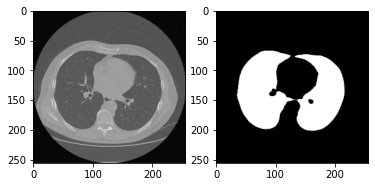

In [ ]:
#예시로 image와 label출력
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_images[20].squeeze(), cmap='gray')
ax[1].imshow(train_labels[20].squeeze(), cmap='gray')

In [ ]:
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.1)#train데이터의 0.1을 valid로 만듬.
valid_images,test_images,valid_labels, test_labels = train_test_split(valid_images, valid_labels, test_size=0.1)#valid의 0.1을 test로 만듬.

In [ ]:
print(train_images.shape) # Batch, Width, Height, channel
print(train_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(240, 256, 256, 1)
(240, 256, 256, 1)
(24, 256, 256, 1)
(24, 256, 256, 1)
(3, 256, 256, 1)
(3, 256, 256, 1)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=10000).batch(32)#batch_size 32개로 각각의 데이터셋 생성
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).shuffle(buffer_size = 10000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(buffer_size = 10000).batch(1)

참고용)컨볼루션 출력 shape 공식
우리는 어차피 Conv할때 padding='same'으로 주었기에 입력과 출력의 사이즈는 똑같고 channel만 바뀐다.

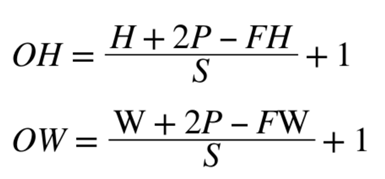

In [ ]:
#모델 설계
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)#32개의 필터를 사용하고 필터의 크기는 3x3이다. 패딩으로 출력이 입력과 같은 shape가 되게 한다.
net = MaxPooling2D(pool_size=2, padding='same')(net)#크기를 반으로 줄인다.
#(128, 128, 32)_channel은 Conv2D때문에, 사이즈는 pooling때문에 변함.

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
#(64, 64, 64)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)
#(32, 32, 128)

net = Dense(128, activation='relu')(net)
#(32, 32, 128)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)#활성화함수를 upsampling시에 바꾼 이유가 비선형성을 추가하기 위함이 아닌가 싶음.
#(64, 64, 128)_upsampling에서 2배로 늘림.

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)
#(128, 128, 64)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)
#(256, 256, 1)

model = Model(inputs=inputs, outputs=outputs)#모델 입출력 연결

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])#손실함수로 crossentropy를 사용하고, back propagation시 adam을 사용한다.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=5, verbose=1)#모델이 과적합된다 싶으면 정해진 epoch가 아니어도 멈춘다.
checkpointer = ModelCheckpoint('model-Lung_segmentation.h5', verbose=1, save_best_only=True)#모델의 값을 수시로 저장할 것인데 최상의 값만 저장한다.

from tensorflow.keras.callbacks import ReduceLROnPlateau#val_loss가 정체되어있다면 learning_rate를 factor배로 감소시켜 세밀한 러닝이 가능하게 한다.

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=100,callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05),
    checkpointer, earlystopper
])#모델을 train_dataset과 validation_dataset을 사용하여 학습할 것인데, 100epoch를 훈련하고, 모델의 상태를 주기적으로 기록하고 상황에따라 learning_rate를 감소시킨다.


Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.5875 - acc: 0.6944 - mse: 0.1924
Epoch 1: val_loss improved from inf to 0.50962, saving model to model-Lung_segmentation.h5
8/8 [==============================] - 21s 695ms/step - loss: 0.5875 - acc: 0.6944 - mse: 0.1924 - val_loss: 0.5096 - val_acc: 0.7698 - val_mse: 0.1635 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.4841 - acc: 0.7486 - mse: 0.1581
Epoch 2: val_loss improved from 0.50962 to 0.44054, saving model to model-Lung_segmentation.h5
8/8 [==============================] - 2s 317ms/step - loss: 0.4841 - acc: 0.7486 - mse: 0.1581 - val_loss: 0.4405 - val_acc: 0.7736 - val_mse: 0.1424 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.4342 - acc: 0.7496 - mse: 0.1434
Epoch 3: val_loss improved from 0.44054 to 0.42368, saving model to model-Lung_segmentation.h5
8/8 [==============================] - 2s 196ms/step - loss: 0.4342 - acc: 0.7496 - 

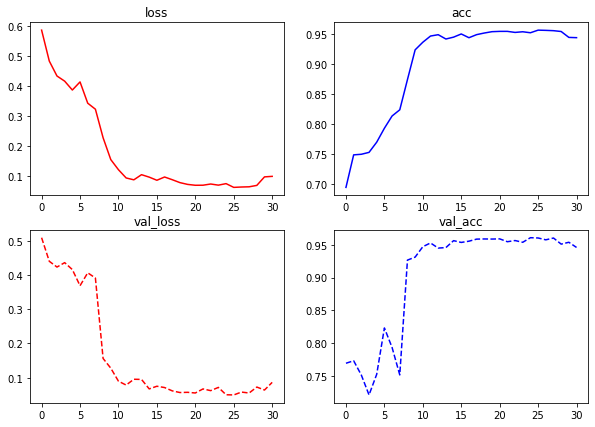

In [ ]:
#train&validation data에 대해 모델이 리턴한 loss과 acc를 가시화.
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

In [ ]:
#테스트 데이터를 이용한 모델의 평가
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08839967101812363
Test accuracy: 0.9412994384765625


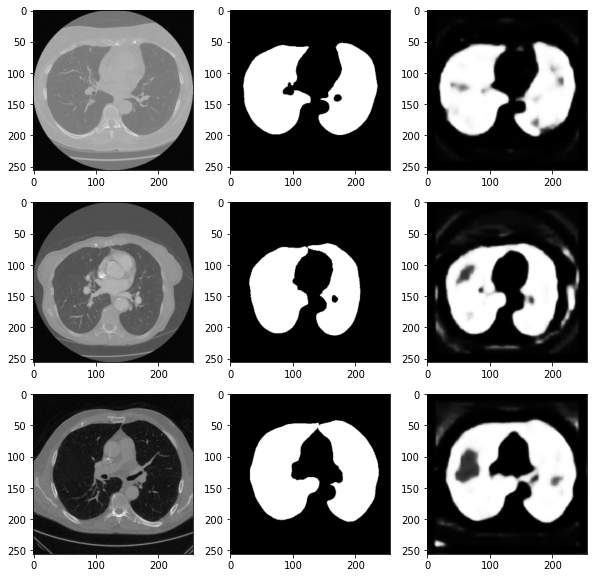

In [ ]:
#테스트 데이터 3개를 predict하게 시킨뒤 결과 가시화
preds = model.predict(test_images)
test_images
fig, ax = plt.subplots(len(test_images), 3, figsize=(10, 10))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(test_labels[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')